In [8]:
#codigo para ocular warnings en el código
from IPython.display import HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pylab as plt
plt.rcParams['font.size'] = 16

# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> IMT 2200 - Introducción a Ciencia de Datos
**Pontificia Universidad Católica de Chile**<br>
**Semestre 2022-2**<br>
**Profesora:** Paula Aguirre <br>

## Clase 25: Análisis de Componentes Principales (PCA)

En este ejercicio, veremos cómo aplicar el análisis de componentes principales para reducir la dimensionalidad de un conjunto de datos de imágenes, y así reducir el tiempo de entrenamiento de un algoritmo de clasificación.

Como datos de entrada, utilizaremos el dataset "Labeled Faces in the Wild", generado para el entrenamiento de modelos de reconocimiento de imágenes (caras).

http://vis-www.cs.umass.edu/lfw/

La lectura e inspección de este conjunto de datos está implementado en el módulo `datasets` de `sklearn`: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html



In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

## 1. Datos de entrada.

In [2]:
from sklearn.datasets import fetch_lfw_people

# Descargar imágenes, como arreglos de numpy. Solo datos de personas con mínimo 3 imágenes
lfw_people = fetch_lfw_people(min_faces_per_person=3)

In [3]:
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [4]:
# nº y forma de imágenes
n_samples, h, w = lfw_people.images.shape
print("n_imagenes: %d, %dx%d pixeles" %(n_samples,h,w))


n_imagenes: 7606, 62x47 pixeles


In [13]:
lfw_people.target_names

array(['Aaron Peirsol', 'Abdoulaye Wade', 'Abdullah', 'Abdullah Gul',
       'Abdullah al-Attiyah', 'Abel Pacheco',
       'Abid Hamid Mahmud Al-Tikriti', 'Adam Sandler', 'Adel Al-Jubeir',
       'Adolfo Aguilar Zinser', 'Adrien Brody', 'Ahmed Chalabi',
       'Ai Sugiyama', 'Aicha El Ouafi', 'Akbar Hashemi Rafsanjani',
       'Akhmed Zakayev', 'Al Gore', 'Al Pacino', 'Al Sharpton',
       'Alan Greenspan', 'Alastair Campbell', 'Albert Costa',
       'Alec Baldwin', 'Alejandro Avila', 'Alejandro Toledo',
       'Aleksander Kwasniewski', 'Alex Sink', 'Alexander Downer',
       'Alexander Losyukov', 'Alexandra Stevenson', 'Ali Khamenei',
       'Ali Naimi', 'Allyson Felix', 'Alvaro Noboa',
       'Alvaro Silva Calderon', 'Alvaro Uribe', 'Amanda Bynes',
       'Amelia Vega', 'Amelie Mauresmo', 'Amer al-Saadi', 'Ana Guevara',
       'Ana Palacio', 'Anastasia Myskina', 'Anders Ebbeson',
       'Anders Fogh Rasmussen', 'Andre Agassi', 'Andrew Weissmann',
       'Andy Roddick', 'Angela Basset

In [14]:
lfw_people.data.shape

(7606, 2914)

In [21]:
lfw_people.target_names.shape

(901,)

In [6]:
# para ML se usan los datos directamente como un arreglo de h*w pixeles. Cada pixel es un "feature"
X=lfw_people.data
n_features = lfw_people.data.shape[1]

# la etiqueta a predecir es el ID de la persona en la imagen
y=lfw_people.target

#cada id corresponde a un nombre
target_names = lfw_people.target_names
y_names=[target_names[x] for x in y]

#numero de personas distintas en el dataset
n_classes = target_names.shape[0]

print("Dataset:")
print("n_imagenes: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Dataset:
n_imagenes: 7606
n_features: 2914
n_classes: 901


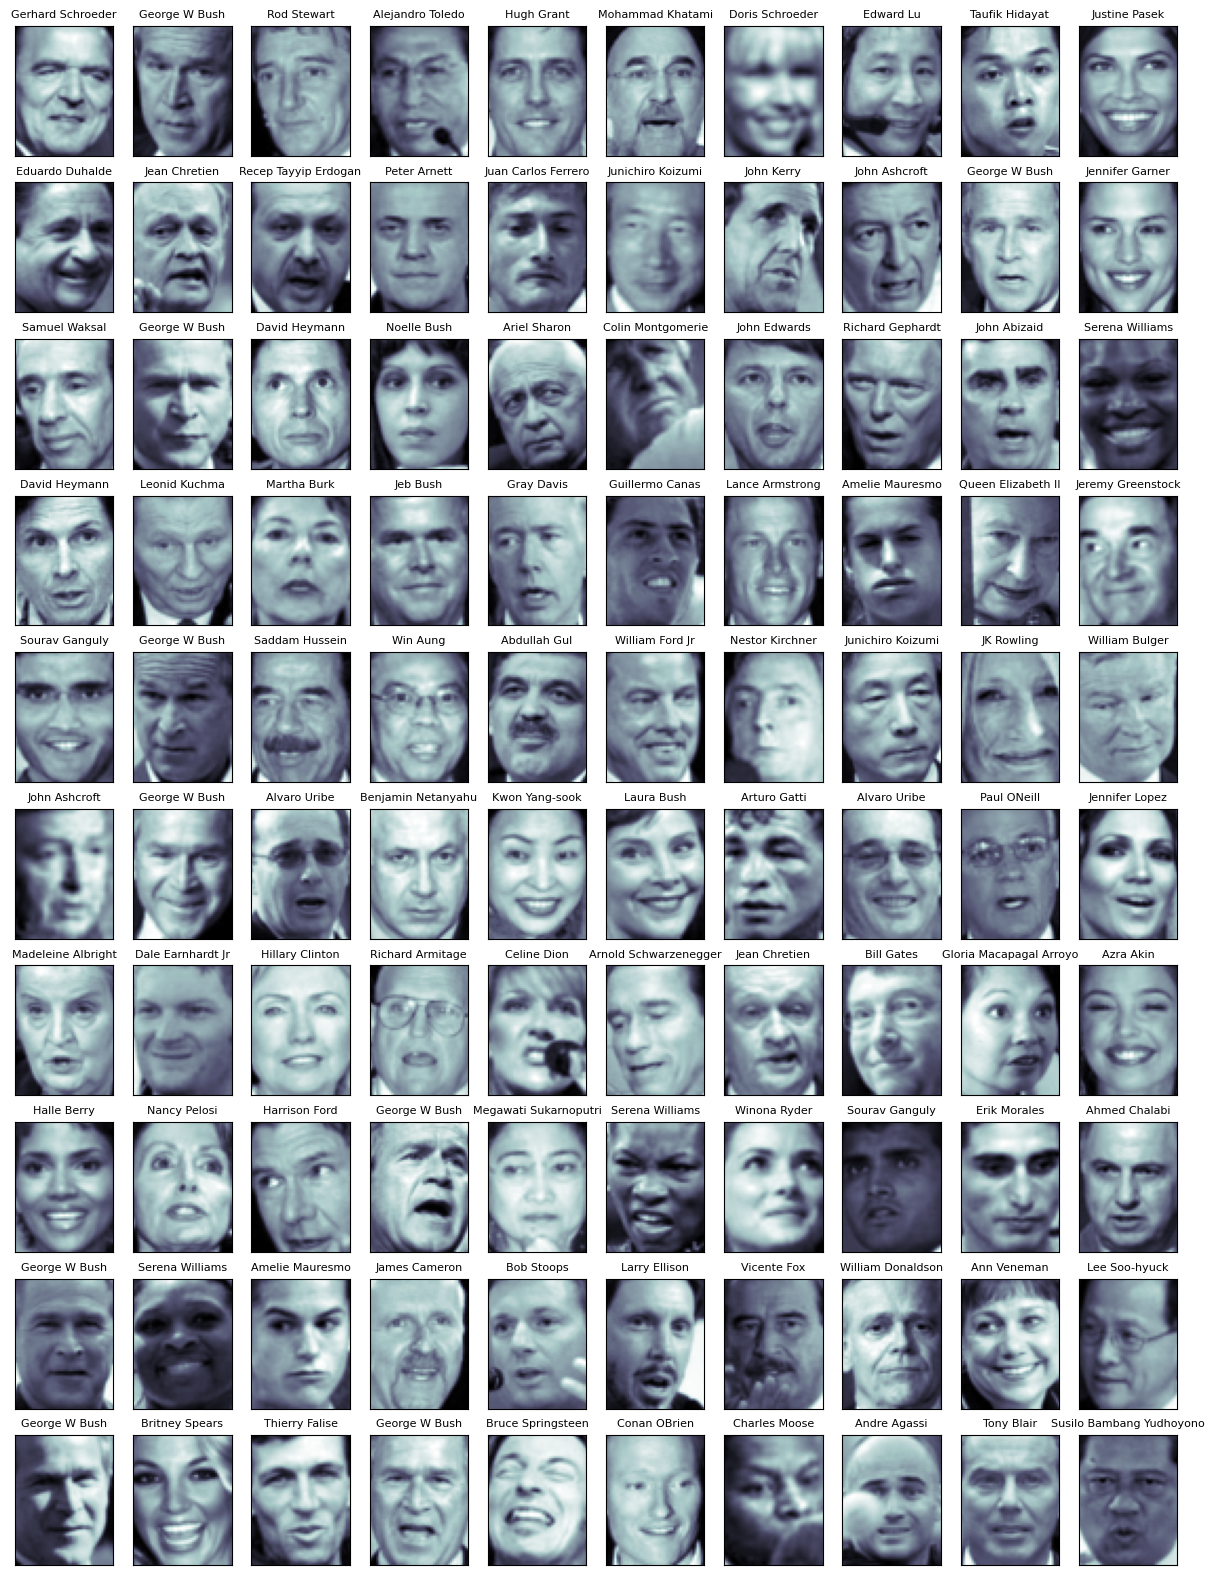

In [7]:
#graficamos algunas caras

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(15, 20))

# plot several images
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(X[i].reshape(h,w), cmap=plt.cm.bone)
    ax.set_title('%s'%y_names[i],fontsize=8)

In [22]:
names, counts = np.unique(y_names, return_counts=True)
df=pd.DataFrame(columns=['name','nImages'])
df['name']=names
df['nImages']=counts
df.sort_values(by='nImages')

AttributeError: type object 'object' has no attribute 'dtype'

In [17]:
#para evitar datos muy desbalanceados, conservaremos sólo max 50 imágenes por persona
mask = np.zeros(lfw_people.target.shape , dtype=np.bool )

for target in np.unique(lfw_people.target ): 
    mask[np.where(lfw_people.target ==target)[0][:50]] = 1 
    
X = lfw_people.data[mask] 
y =np.int_(lfw_people.target[mask])
y_names=[target_names[x] for x in y]

X.shape

(6646, 2914)

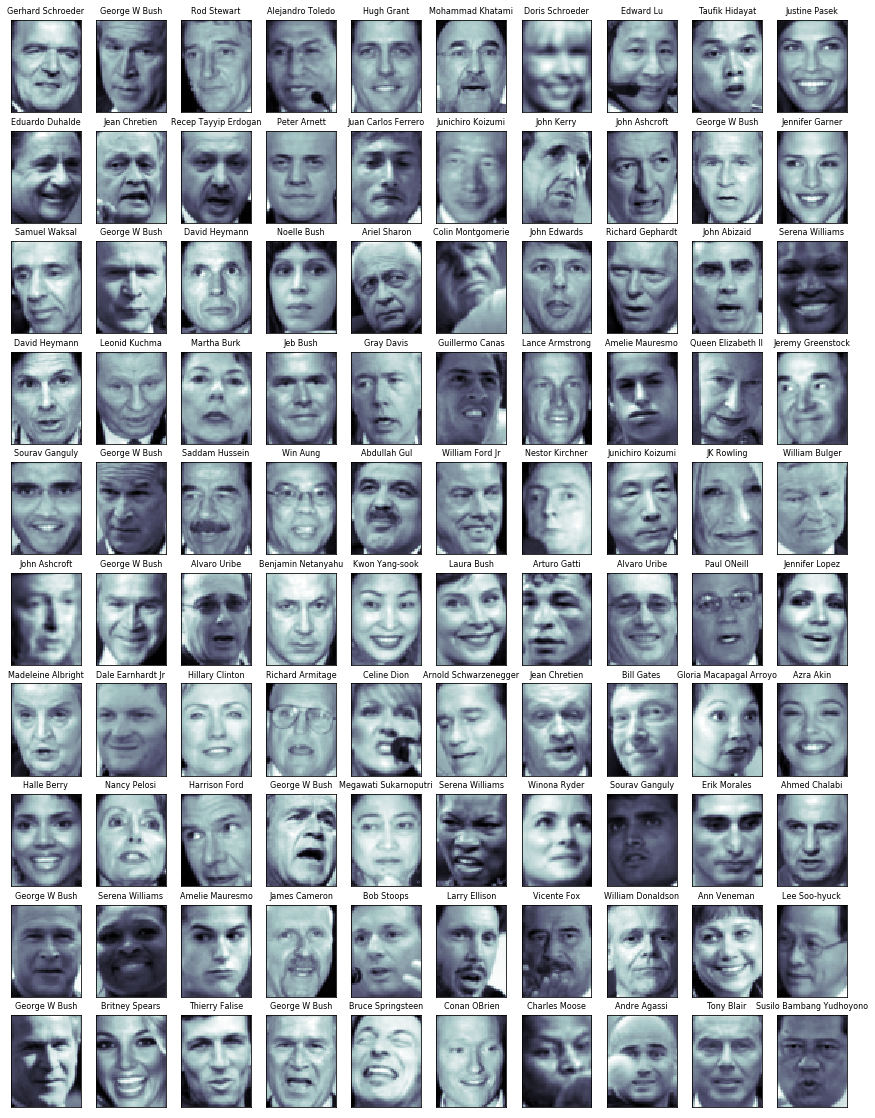

In [18]:
#volvemos a graficar el dataset filtrado
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(15, 20))
# plot several images
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(X[i].reshape(h,w), cmap=plt.cm.bone)
    ax.set_title('%s'%target_names[y[i]],fontsize=8)

## 2. Entrenamiento de un modelo de clasificacion kNN.

En el caso del dataset LFW, el objetivo es entrenar un modelo de clasificación que permita identificar a qué persona corresponde cada imagen (cara). 

Como primera aproximación, podríamos entrenar por ejemplo un clasificador kNN, utilizando el dataset original con todas sus dimensiones. Luego, podemos repetir el ejercicio con un dataset reducido, para comparar el tiempo y calidad del entrenamiento.

In [21]:
#generamos los datasets de entrenamiento y prueba
from sklearn.model_selection import train_test_split
train_img, test_img, train_lbl, test_lbl = train_test_split(X,y, test_size=0.2, random_state=0)
train_img.shape

(5316, 2914)

In [20]:
#entrenamos un modelo knn con k=1, y tomamos el tiempo
import timeit
#tiempo inicial
start_time = timeit.default_timer()

# code you want to evaluate
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_img,train_lbl)
test_pred=neigh.predict(test_img)

#tiempo transcurrido
elapsed = timeit.default_timer() - start_time
print('Tiempo de entrenamiento (dataset original):',elapsed, 's')

/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


Tiempo de entrenamiento (dataset original): 46.390342762000046 s


In [22]:
test_pred

array([ 95, 578, 455, ...,  64, 508, 279])

In [23]:
from sklearn.metrics import accuracy_score

print('Accuracy (dataset original):',accuracy_score(test_lbl,test_pred))

Accuracy (dataset original): 0.1037593984962406


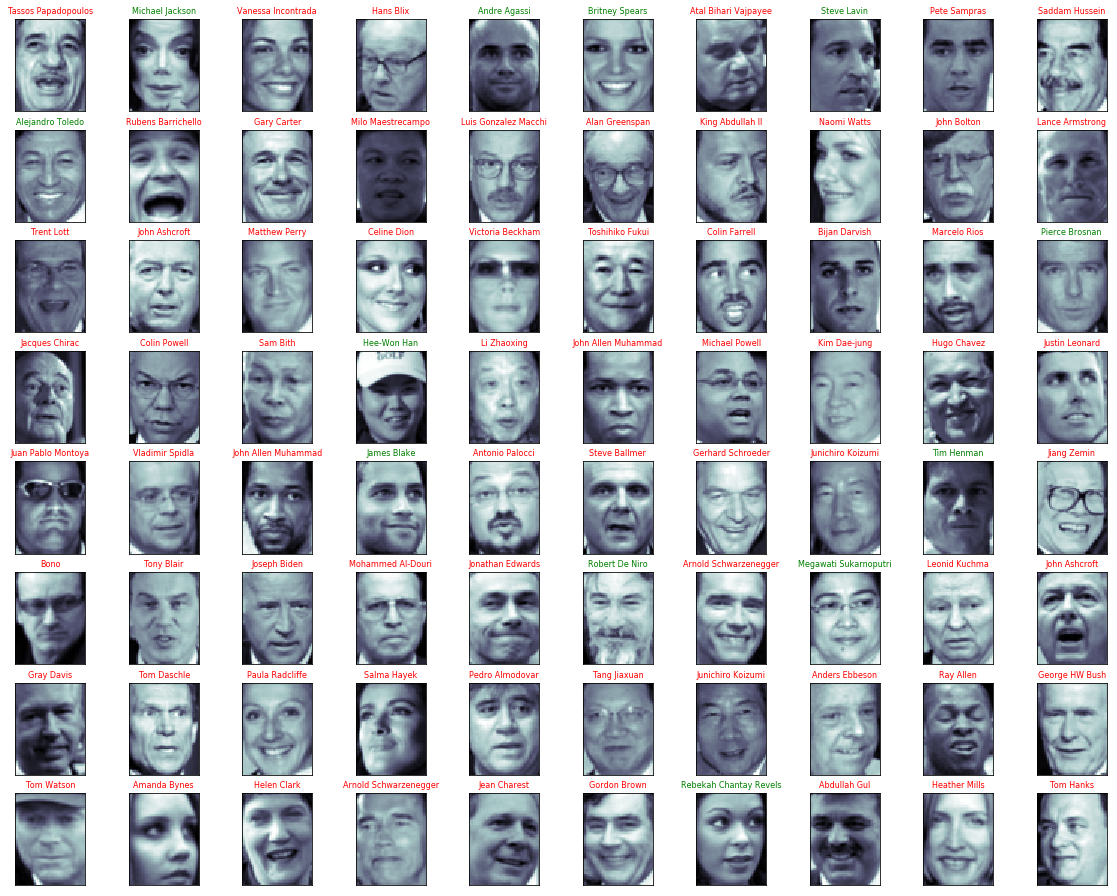

In [24]:
#grafiquemos los resultados del entrenamiento
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))

for i in range(80):
    ax = fig.add_subplot(10,10, i + 1, xticks=[], yticks=[])
    ax.imshow(test_img[i].reshape(h,w), cmap=plt.cm.bone)
       
    if test_pred[i]==test_lbl[i]:
        ax.set_title('%s'%(target_names[test_lbl[i]]),fontsize=8,color='green')
    else:
        ax.set_title('%s'%(target_names[test_lbl[i]]),fontsize=8,color='red')

## 3. Análisis de Componentes Principales.

Ahora repetiremos el ejercicio, pero aplicando primero reducción de dimensionalidad al dataset de imágenes, mediante análisis de componentes principales.

En el PCA, es necesario escalar los datos para evitar efectos de escala entre componentes. Para ello, el procedimiento a aplicar es:
- Separar los datos en conjuntos de entrenamiento y prueba.
- Definir un método de escalemiento (ej: `StandardScaler`).
- Calcular los parámetros del escalamiento para los datos de entrenamiento.
- Aplicar *el mismo* escalamiento a los datos de prueba.

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Ajustar parámetros de escalamiento.
scaler.fit(train_img)

# Aplicar el mismo escalalmiento a datos de entrenamiento y prueba.
train_img_sc = scaler.transform(train_img)
test_img_sc = scaler.transform(test_img)

In [27]:
train_img_sc.shape

(5316, 2914)

### Definifición del número de componentes principales.

En el algoritmo PCA, el principal parámetro a definir es el número de componentes principales a considerar. Para determinarlo, podemos generar todas las componentes, y analizar la fracción de varianza explicada por cada una de ellas. 

In [28]:
pca = PCA() # no especificamos aun el nº de componentes, para analizar la varianza explicada
pca.fit(train_img)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [31]:
pca.components_.shape

(2914, 2914)

In [34]:
pca.explained_variance_ratio_

array([2.23219961e-01, 1.07113145e-01, 8.41495842e-02, ...,
       4.84370855e-09, 4.70681139e-09, 4.54815341e-09], dtype=float32)

(0, 500)

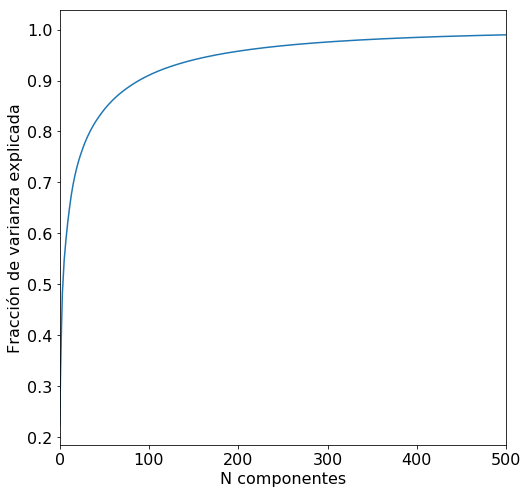

In [38]:
#graficamos la fracción de varianza *acumulada* para distintos números de componentes

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('N componentes')
ax.set_ylabel('Fracción de varianza explicada')
ax.set_xlim(0,500)

Del gráfico anterior, podemos identificar el número de componentes requerido para representar una fracción suficientemente alta de la varianza total de los datos, por ejemplo del orden de 80-90%.

Una vez definido el número de componentes a utilizar, entrenamos el método de reducción de dimensionalidad definitivo, repetimos el entrenamiento del clasificador kNN y comparamos los reultados.

In [39]:
pca = PCA(n_components=200) # ahora sí especificamos el nº de componentes, de tal forma que la varianza explicada sea alta
pca.fit(train_img)

#aplicamos la transformación a los datos de entrenamiento y prueba
train_img_pca = pca.transform(train_img)
test_img_pca = pca.transform(test_img)

In [40]:
#aplicamos la transformación inversa para visualizar los datos con dimensionalidad reducida
approx = pca.inverse_transform(train_img_pca)
approx.shape

(5316, 2914)

In [41]:
#¿qué representa cada componente principal? Veamos por ejemplo PC1
pc1=pca.components_[0]*train_img[0]
pc1.shape

(2914,)

<Figure size 1080x1440 with 0 Axes>

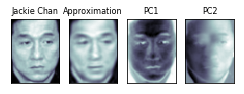

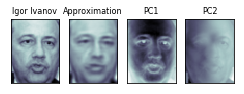

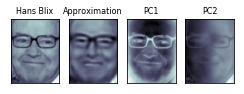

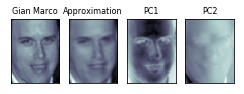

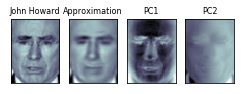

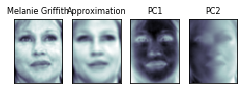

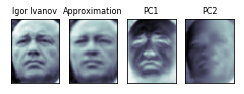

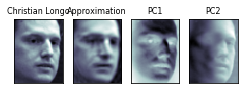

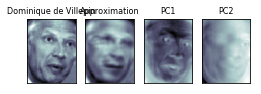

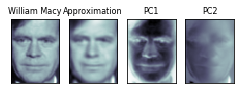

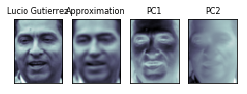

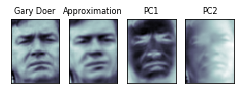

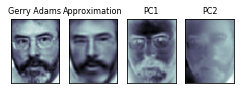

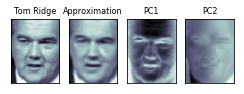

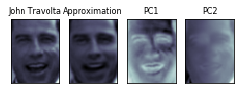

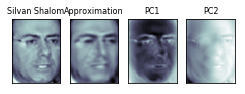

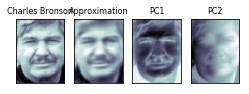

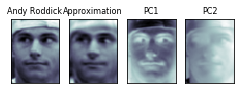

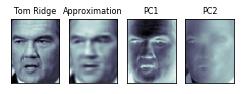

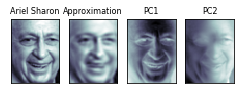

In [43]:
#graficamos las imagenes con dimensionalidad reducida (algunos ejemplos)

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(15, 20))

for i in range(20):
    fig = plt.figure(figsize=(4,2))
    ax1 = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
    ax2 = fig.add_subplot(1, 4, 2, xticks=[], yticks=[])
    ax3 = fig.add_subplot(1, 4, 3, xticks=[], yticks=[])
    ax4 = fig.add_subplot(1, 4, 4, xticks=[], yticks=[])

    #imagen original
    ax1.imshow(train_img[i].reshape(h,w), cmap=plt.cm.bone)
    ax1.set_title('%s'%target_names[train_lbl[i]],fontsize=8)
    
    #imagen transformada
    ax2.imshow(approx[i].reshape(h,w), cmap=plt.cm.bone)
    ax2.set_title('Approximation',fontsize=8)
    
    #pc1
    pc1=pca.components_[0]*train_img[i]
    ax3.imshow(pc1.reshape(h,w), cmap=plt.cm.bone)
    ax3.set_title('PC1',fontsize=8)
    
    #pc2
    pc2=pca.components_[1]*train_img[i]
    ax4.imshow(pc2.reshape(h,w), cmap=plt.cm.bone)
    ax4.set_title('PC2',fontsize=8)
    
        

## 4. Entrenamiento de clasificador kNN con dimensionalidad reducida.

In [44]:
#entrenamos el clasificador ocn el dataset transformado (100 componentes principales)
#tiempo inicial
start_time = timeit.default_timer()

# code you want to evaluate
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_img_pca,train_lbl)
test_pred=neigh.predict(test_img_pca)
accuracy_score(test_lbl,test_pred)

#tiempo transcurrido
elapsed = timeit.default_timer() - start_time
print('Time elapsed:',elapsed)

/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


Time elapsed: 3.213442087999738


In [45]:
accuracy_score(test_lbl,test_pred)

0.10902255639097744

In [52]:
components=np.arange(1,300,20)
times=[]
accuracy=[]

for ncom in components:
    print('N components:',ncom)
    pca = PCA(n_components=ncom) 
    pca.fit(train_img)

    #aplicamos la transformación a los datos de entrenamiento y prueba
    train_img_pca = pca.transform(train_img)
    test_img_pca = pca.transform(test_img)
    
    start_time = timeit.default_timer()

    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(train_img_pca,train_lbl)
    test_pred=neigh.predict(test_img_pca)
    
    elapsed = timeit.default_timer() - start_time
    times.append(elapsed)
    accuracy.append(accuracy_score(test_lbl,test_pred))

N components: 1


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 21


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 41


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 61


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 81


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 101


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 121


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 141


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 161


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 181


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 201


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 221


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 241


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 261


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


N components: 281


/Users/paguirre/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


In [53]:
components,times,accuracy

(array([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241,
        261, 281]),
 [0.05041029699987121,
  0.193663801999719,
  0.33792401000027894,
  0.8139752499992028,
  0.9506892680001329,
  1.2555658549999862,
  1.5922570619995895,
  1.74340131200006,
  2.3145964369996364,
  2.5256643080001595,
  3.36683848300072,
  3.331064274999335,
  3.568870787999913,
  3.9712143970000398,
  4.18953997799963],
 [0.0030075187969924814,
  0.06390977443609022,
  0.0887218045112782,
  0.0962406015037594,
  0.10075187969924812,
  0.10225563909774436,
  0.10526315789473684,
  0.10601503759398496,
  0.10751879699248121,
  0.10751879699248121,
  0.10977443609022557,
  0.10977443609022557,
  0.10751879699248121,
  0.10751879699248121,
  0.10827067669172932])

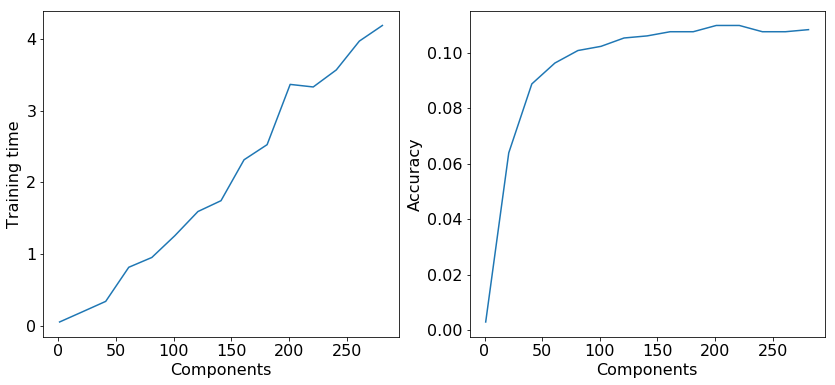

In [54]:
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(121,xlabel='Components')
ax2=fig.add_subplot(122,xlabel='Components')

ax1.plot(components, times)
ax2.plot(components, accuracy)

ax1.set_ylabel('Training time')
ax2.set_ylabel('Accuracy');